# 分布式梯度提升决策树

回归前面的实验，我们已经学习了决策树，决策树是一种常见的监督学习模型，可以用于分类和回归任务。它通过将数据集分割为不同的分支，创建一棵树状结构来做出决策。每个分支代表了一个特征条件，最终叶子节点代表预测的结果

梯度提升（Gradient Boosting）是一种集成机器学习方法，它通过组合多个性能一般的模型来增强整体的预测能力。这种方法的关键在于，每一个模型都尝试去纠正前一个模型的预测失误。具体操作时，梯度提升会利用损失函数的梯度信息来指导后续模型的调整方向，目的是逐步降低整体的预测误差。

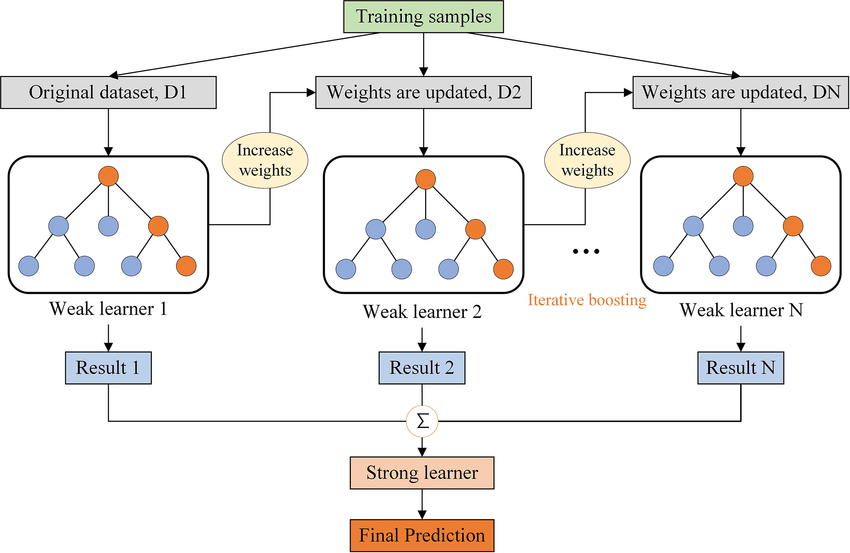

1. **初始模型**
   - 在梯度提升中，初始模型通常是一个非常简单的模型，如一个决策树。这个初始模型也称为基学习器或弱学习器。
   - 初始模型不需要很复杂，因为它只是整个提升过程的起点。它的目的是提供一个基本的预测，即使这个预测并不十分准确。
2. **残差拟合**
   - 一旦有了初始模型的预测结果，算法接下来会计算每个训练样本的残差，即真实值与预测值之间的差异。
   - 这些残差反映了初始模型的不足之处，是算法接下来需要集中改进的部分。
3. **迭代更新**
   - 在每一轮迭代中，新的弱学习器都会被训练来拟合上一轮产生的残差。
   - 通过这种方式，每一轮都专注于纠正前一轮模型未能解决的错误。因此，每一轮的学习器都在尝试解决一个更难的问题，即减少残差。
   - 每个新的弱学习器通常是一个简单的模型，比如一个浅层决策树。
4. **模型合并**
   - 每个弱学习器产生的预测结果不是独立使用的，而是与之前的模型合并，通常是通过加权求和的方式。
   - 合并后的模型在每次迭代后都会更新，整合新学习器的预测结果，以此提高整体预测的精度。
   - 通过多次迭代，模型逐渐积累更多关于数据的知识，并不断减小训练误差。


## 梯度提升决策树

梯度提升决策树（GBDT, Gradient Boosting Decision Trees）是将梯度提升与决策树结合的算法。在 GBDT 中，多个决策树被逐步训练，每棵树都试图拟合上一次的预测误差。GBDT 能够有效处理回归和分类任务，并且在实践中表现非常优异。

GBDT 的关键特点：
- 每个树的目标是减少前一棵树的预测误差。
- 通过梯度下降的方式来最小化损失函数。
- 适用于各种类型的损失函数（如均方误差、对数损失等）。
GBDT 的主要缺点在于训练速度较慢，尤其在处理大规模数据时，由于模型的逐步训练和弱模型的迭代更新，这种方法计算复杂度较高。

**分布式梯度提升**    
随着数据规模的增加，传统的 GBDT 在大规模数据集上的训练效率变得低下。为了提高效率，研究人员提出了分布式梯度提升。这种方法可以将数据分片，分配到多个计算节点上并行计算，从而加速模型的训练。分布式计算利用多核处理器和集群资源，使得模型能够在更大的数据集上进行训练，并且缩短训练时间。

然而，传统的分布式梯度提升在工程实现上仍然面临许多挑战，如如何合理分配计算任务、管理内存资源等。

# 回归任务

In [9]:
import xgboost as xgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

diabetes = load_diabetes() # 数据
X,y = diabetes.data,diabetes.target
print("Data Shape:", X.shape, y.shape)

Data Shape: (442, 10) (442,)


In [17]:
# 变量的统计特征
print("Min:", np.min(diabetes.target))
print("Max:", np.max(diabetes.target))
print("Mean:", np.mean(diabetes.target))
print("Standard Deviation:", np.std(diabetes.target))

Min: 25.0
Max: 346.0
Mean: 152.13348416289594
Standard Deviation: 77.00574586945044


数据集包括 442 个病人的 10 个生理特征（年龄、性别、体重指数、血压等）和一年后的病情进展情况，这将作为我们的目标变量

In [10]:
# 数据预处理 
# 把数据拆分成训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


虽然 XGBoost 对数据缩放的要求不像线性模型那样严格，但进行标准化处理——减去均值并除以标准差，仍然有助于优化算法的性能，特别是在涉及到梯度和步长选择的算法中。

In [11]:
# 标准化数据
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

**模型训练**   
在模型训练步骤中，我们首先将数据转换为 XGBoost 的 DMatrix 格式，这是一种专为 XGBoost 优化的数据结构，可以使得模型运行更快。

In [12]:
# 将数据转换为 DMatrix 格式，这是 XGBoost 的高效数据格式
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label = y_test)

In [13]:
# 设置参数
params = {
    'objective': 'reg:squarederror',  # 回归任务的目标函数
    'max_depth': 4,                   # 树的最大深度
    'eta': 0.1,                       # 学习率
    'subsample': 0.8,                 # 随机采样比例
    'colsample_bytree': 0.8           # 每棵树使用特征的比例
}

In [15]:
# 训练模型
model = xgb.train(params, dtrain, num_boost_round=100)

In [16]:
from sklearn.metrics import mean_squared_error

# 在测试集上进行预测
y_pred = model.predict(dtest)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 3060.3882


In [ ]:
new_data = np.random.randn(3, 10)
dnew = xgb.DMatrix(new_data)
new_pred = model.predict(dnew)
print(f"Predicted value: {new_pred}")

Predicted value: [225.52388 183.21236 152.57228]


(None, (3, 10))

# 分类任务

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
x,y = iris.data,iris.target
print(x.shape,y.shape)
print(set(y))

(150, 4) (150,)
{0, 1, 2}


In [23]:
# 数据预处理，划分数据集和测试集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [24]:
# 归一化
x_tarin = scalar.fit_transform(x_train)
x_test = scalar.fit_transform(x_test) 

In [25]:
# 转换成XGB格式的数据
dtrain = xgb.DMatrix(x_train,label = y_train)
dtest = xgb.DMatrix(x_test,label = y_test)


In [26]:
# 设置参数
params = {
    'objective': 'multi:softmax',  # 分类任务的目标函数
    'num_class': 3,                # 类别数量
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# 训练模型
model = xgb.train(params, dtrain, num_boost_round=100)

In [27]:
from sklearn.metrics import accuracy_score

# 在测试集上进行预测
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3333


In [28]:
new_data = np.random.randn(3, 4)
dnew = xgb.DMatrix(new_data)
new_pred = model.predict(dnew)
print(f"Predicted class: {new_pred}")

Predicted class: [0. 0. 0.]
